In [1]:
import os

In [2]:
# Define names of datasets to select
dataset_target_name_list = ["ENZYMES", "DD", "COLLAB"]

# Define datasets destination
datasets_folder = "datasets/"

# List of all datasets names
dataset_name_list = os.listdir(datasets_folder)

# List of dataset files, label files and  node feature vectors files
dataset_file_list = []
dataset_label_file_list = []
dataset_feature_file_list = []

# File paths of dataset edge indexes and labels
for dataset_name in dataset_name_list:
    if(dataset_name in dataset_target_name_list):
        dataset_file_list.append(os.path.join(datasets_folder, dataset_name, f"{dataset_name}.pth"))
        dataset_feature_file_list.append(os.path.join(datasets_folder, dataset_name, f"{dataset_name}.pt"))
        dataset_label_file_list.append(os.path.join(datasets_folder, dataset_name, f"{dataset_name}.global_cc"))

In [3]:
import torch

In [4]:
# Enable gpu for training, validation and test if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# List of datasets
dataset_list = []

# List of datasets node feature vectors
dataset_feature_list = []

# List of dataset labels list
dataset_labels_list = []

for dataset_file, dataset_feature_file, dataset_label_file in zip(dataset_file_list, dataset_feature_file_list, dataset_label_file_list):
    # Load dataset
    dataset = torch.load(dataset_file, weights_only=True)

    # Load dataset node feature vectors
    dataset_feature = torch.load(dataset_feature_file, weights_only=False)

    # Load labels from file .global_cc
    with open(dataset_label_file, 'r') as f:
        dataset_labels = [float(line.strip()) for line in f.readlines()]

    # Prepare dataset list to manage datasets easily
    dataset_list.append(dataset)

    # Prepare dataset node feature vectors list
    dataset_feature_list.append(dataset_feature)

    # Prepare dataset labels
    dataset_labels_list.append(dataset_labels)

In [6]:
from torch_geometric.data import Data

In [7]:
# Data structure for storing Data object of graphs
data_list = []

# Create pytorch geometric Data objects from graphs
for dataset, dataset_feature, dataset_labels in zip(dataset_list, dataset_feature_list, dataset_labels_list):
    for i, (key, tensor) in enumerate(dataset.items()):
        # Set edge index, node features and label of the current graph
        edge_index = tensor.coalesce().indices()
        num_nodes = edge_index.max().item() + 1
        x = dataset_feature[i + 1]
        label = torch.tensor([dataset_labels[i]])

        data = Data(x=x, edge_index=edge_index, y=label)
        data_list.append(data)

In [8]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)

In [9]:
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

In [10]:
# DataLoader split in train, validation and test
total_len = len(data_list)
train_len = int(0.8 * total_len)
validation_len = int(0.1 * total_len)
test_len = total_len - train_len - validation_len

train_data, validation_data, test_data = random_split(data_list, [train_len, validation_len, test_len])

In [11]:
# Set batch size
batch_size = 128

# DataLoader structures for train, valdation and test
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [12]:
import torch.nn.functional as func
from torch.nn import Sequential, Linear, ReLU, ModuleList
from torch_geometric.nn import GINConv, BatchNorm, global_mean_pool

In [13]:
# GNN model definition
class ClusteringCoefficientGNN(torch.nn.Module):
    # Model architecture
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(ClusteringCoefficientGNN, self).__init__()

        # Initialize module lists
        self.convs = ModuleList()
        self.bns = ModuleList()
        
        # Input GIN layer
        self.convs.append(GINConv(
            Sequential(
                Linear(in_channels, hidden_channels[0]),
                ReLU(),
                Linear(hidden_channels[0], hidden_channels[0])
            ), train_eps=self.training
        ))
        self.bns.append(BatchNorm(hidden_channels[0]))
        
        # GIN layers (hidden layers)
        for i in range(num_layers - 1):
            self.convs.append(GINConv(
                Sequential(
                    Linear(hidden_channels[0] if i == 0 else hidden_channels[1], hidden_channels[1]),
                    ReLU(),
                    Linear(hidden_channels[1], hidden_channels[1])
                ), train_eps=self.training 
            ))

            self.bns.append(BatchNorm(hidden_channels[1]))
        
        # Output fully connected layer
        self.linear = Sequential(
            Linear(hidden_channels[1], hidden_channels[1]),
            ReLU(),
            Linear(hidden_channels[1], out_channels)
        )
        
        self.dropout = dropout

    # Forward pass (inference)
    def forward(self, x, edge_index, batch):
        # GIN layers
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = func.relu(x)
            x = func.dropout(x, p = self.dropout, training = self.training)

        # Global mean pool (graph-level features)
        x = global_mean_pool(x, batch)

        # Fully connected layer
        x = self.linear(x)
        x = func.relu(x)

        return x

In [14]:
# Training function
def train(model, train_data_loader, optimizer, loss_function):
    # Set GNN model to training mode
    model.train()
    train_total_loss = 0

    # Train over all graphs in training_data_loader
    for data in train_data_loader:
        # Clear the gradient
        optimizer.zero_grad()

        # Move data to device (gpu if available)
        data = data.to(device)

        # Forward pass
        out = model(data.x, data.edge_index, data.batch)

        # Compute loss
        loss = loss_function(out.squeeze(dim=1), data.y)
        optimizer.step()

        train_total_loss += loss.item()

    return train_total_loss / len(train_data_loader)

In [15]:
# Evaluation function (for validation and test)
@torch.no_grad()
def evaluate(model, evaluation_data_loader, loss_function):
    # Set model to evaluation mode
    model.eval()
    evaluation_total_loss = 0

    # Evaluation over all graphs in evaluation_data_loader
    for data in evaluation_data_loader:
        # Move data to device (gpu if available)
        data = data.to(device)

        # Forward pass
        out = model(data.x, data.edge_index, data.batch)

        # Compute loss
        loss = loss_function(out.squeeze(dim=1), data.y)

        evaluation_total_loss += loss.item()

    return evaluation_total_loss / len(evaluation_data_loader) 

In [16]:
# Number of node features
in_channels = 6

# Output dimension (regression task over scalar numbers)
out_channels = 1

# Hyperparameters for GNN
hidden_channels = [128, 64]

# Number of layers
num_layers = 5

# Training settings
num_epochs = 1000
patience = 100

# Learning rate settings
learning_rate = 0.001
scheduler_ratio = 0.1

# Dropout probability
dropout = 0.2

In [17]:
# Save location in 'model/'
model_folder = "model/"
os.makedirs(model_folder, exist_ok = True)

# Model path
model_path = os.path.join(model_folder, 'graph_gcc_net.pth')

In [18]:
from torch.optim import Adam

In [19]:
# Initialize model
model = ClusteringCoefficientGNN(in_channels, hidden_channels, out_channels, num_layers, dropout)
model.to(device)

# Initialize optimizer and loss function
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# Set a simple step scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs / 4, gamma=scheduler_ratio)

In [20]:
import matplotlib.pyplot as plt

In [21]:
# Initialize lists to store losses for plotting
train_losses = []
validation_losses = []

In [172]:
# Number of epochs the GNN has not obtained better validation loss
patience_counter = 0

# Best validation loss up to now
best_validation_loss = float('inf')

# Best model saved
best_model_save = False

# Training and validation loop
for epoch in range(1, num_epochs + 1):
    # Training step
    train_loss = train(model, train_data_loader, optimizer, loss_function)
    train_losses.append(train_loss)

    # Validation step
    val_loss = evaluate(model, validation_data_loader, loss_function)
    validation_losses.append(val_loss)

    # Training status in current epoch
    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping condition using patience
    if val_loss < best_validation_loss:
        best_validation_loss = val_loss
        patience_counter = 0
        
        # Save current best model (snapshot)
        torch.save(model.state_dict(), model_path)
    else:
        patience_counter += 1
        if(patience_counter == patience):
            print("Patience finished: stopping training")
            print(f"Best validation: {best_validation_loss:.4f}")
            best_model_save = True
            break

    # Scheduler step (if used)
    if scheduler:
        scheduler.step()

Epoch 001, Train Loss: 0.1570, Val Loss: 0.1504
Epoch 010, Train Loss: 0.1581, Val Loss: 0.1513
Epoch 020, Train Loss: 0.1592, Val Loss: 0.1456
Epoch 030, Train Loss: 0.1581, Val Loss: 0.1487
Epoch 040, Train Loss: 0.1580, Val Loss: 0.1474
Epoch 050, Train Loss: 0.1590, Val Loss: 0.1500
Epoch 060, Train Loss: 0.1583, Val Loss: 0.1429
Epoch 070, Train Loss: 0.1588, Val Loss: 0.1424
Epoch 080, Train Loss: 0.1593, Val Loss: 0.1477
Epoch 090, Train Loss: 0.1576, Val Loss: 0.1508
Epoch 100, Train Loss: 0.1579, Val Loss: 0.1452
Epoch 110, Train Loss: 0.1583, Val Loss: 0.1685
Epoch 120, Train Loss: 0.1570, Val Loss: 0.1482
Epoch 130, Train Loss: 0.1580, Val Loss: 0.1528
Epoch 140, Train Loss: 0.1589, Val Loss: 0.1548
Patience finished: stopping training
Best validation: 0.1382


In [173]:
# Load best snapshot if training stopped earlier
if best_model_save == True:
    print("Best validated model loaded")
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
else:
    # Save GNN model, if training not early stopped 
    torch.save(model.state_dict(), model_path)

Best validated model loaded


In [174]:
# Final test phase
test_loss = evaluate(model, test_data_loader, loss_function)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.1473


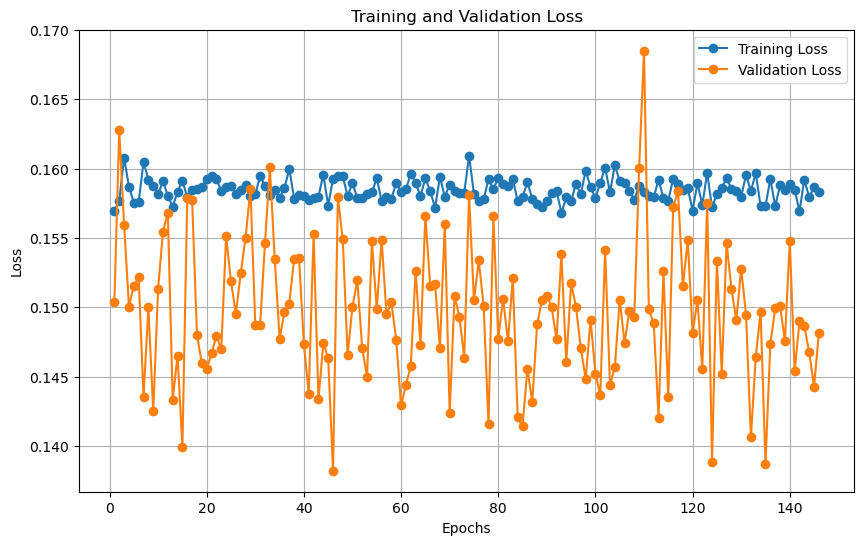

In [175]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

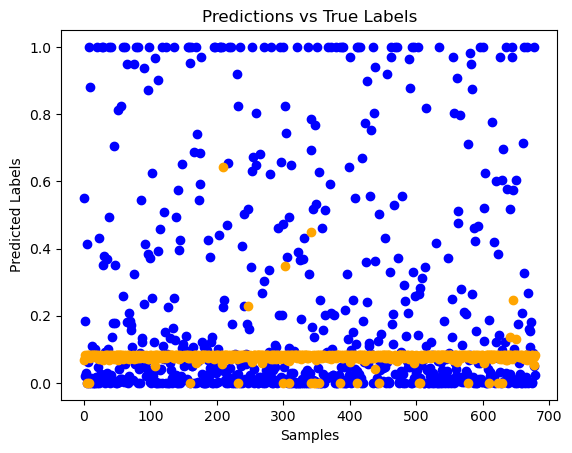

In [22]:
# Load model and set it in evaluation mode
model = ClusteringCoefficientGNN(in_channels, hidden_channels, out_channels, num_layers, dropout)
model.load_state_dict(torch.load("model/graph_gcc_net.pth", weights_only=True))
model.to(device)
model.eval()

# Store predicitons and ground truths
predictions_list = []
ground_truth_list = []

torch.no_grad()
for data in test_data_loader:
    # Move data sample to GPU, if available
    data = data.to(device)

    # Evaluate sample using model
    out = model(data.x, data.edge_index, data.batch)

    # Append predictions and corresponding ground truth
    predictions_list.append(out.cpu())
    ground_truth_list.append(data.y.cpu())

# Concatenate batches both in predictions and ground truths lists
predictions_list = torch.cat(predictions_list).detach().numpy()
ground_truth_list = torch.cat(ground_truth_list).detach().numpy()

# Plot of ground truth vs model predictions
plt.scatter(range(len(ground_truth_list)), ground_truth_list, color='blue', label='Ground Truths')
plt.scatter(range(len(predictions_list)), predictions_list, color='orange', label='Predictions')
plt.xlabel("Samples")
plt.ylabel("Predicted Labels")
plt.title("Predictions vs True Labels")
plt.show()